<a href="https://colab.research.google.com/github/tinghe14/COURSE-2Deep-Learning/blob/main/Copy_of_XG_3DUnet_corrected_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [ ]:
# Monai healthcare image package https://github.com/Project-MONAI/MONAI
# Package documentation: https://docs.monai.io/en/stable/
# Pytorch example: https://colab.research.google.com/drive/1boqy7ENpKrqaJoxFlbHIBnIODAs1Ih1T#scrollTo=qqsFxN84opS1
%pip install -q "monai-weekly[tqdm, nibabel, gdown, ignite]"

     |████████████████████████████████| 805 kB 5.2 MB/s 
     |████████████████████████████████| 251 kB 93.9 MB/s 


In [ ]:
import warnings
warnings.filterwarnings("ignore")  # remove some scikit-image warnings

import monai
monai.config.print_config()

MONAI version: 0.9.dev2218
Numpy version: 1.21.6
Pytorch version: 1.11.0+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 127aef33d48f499b0b07b1aed0543bab1b913765
MONAI __file__: /usr/local/lib/python3.7/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.12.0+cu113
tqdm version: 4.64.0
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
# access dataset from data challenge 
#from monai.apps import DecathlonDataset
# dataloader to prepare it ready for dl model
from monai.data import DataLoader
from monai.metrics import DiceMetric
# chain of transformers (if want to add more: check the documentations in transform, loader section)
# from monai.transforms import \
#     LoadImageD, EnsureChannelFirstD, AddChannelD, ScaleIntensityD, ToTensorD, Compose, \
#     AsDiscreteD, SpacingD, OrientationD, ResizeD, RandAffineD
from monai.transforms import (
    OrientationD,
    Activations,
    AddChannelD,
    AsDiscreteD,
    Compose,
    LoadImageD,
    RandCropByPosNegLabeld,
    RandRotate90d,
    ScaleIntensityD,
    EnsureTyped,
    EnsureType,
    SpacingD,
    RandAffineD,
    ResizeD,
    EnsureChannelFirstD,
    ToTensorD,
    MapTransform
)

import os
import numpy as np
import matplotlib.pyplot as plt
import tarfile

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import autograd, optim
import torch.backends.cudnn as cudnn
import torch.nn as nn
from torch.nn.modules.activation import Softmax
import torchvision.utils as vutils


%matplotlib inline

# Transform, Loader

detailed documentations of pre-processing pipeline: https://github.com/Project-MONAI/tutorials, https://github.com/Project-MONAI/MONAI/wiki/Developer-Guide-Transforms, https://docs.monai.io/en/stable/

In [ ]:
# set your local directory
try:
  from google.colab import drive
  drive.mount('/content/gdrive')
except:
  print("Mounting Failed.")

%cd /content/gdrive/MyDrive/DeepLearningFinalProject/
os.getcwd() 

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1OGu5OMFOKKtjB8OAHxsxZ1_CErQRX-y8/DeepLearningFinalProject


'/content/gdrive/.shortcut-targets-by-id/1OGu5OMFOKKtjB8OAHxsxZ1_CErQRX-y8/DeepLearningFinalProject'

In [ ]:
from glob import glob
from pathlib import Path

ROOT_DIR = "/content/gdrive/MyDrive/DeepLearningFinalProject/Task01_BrainTumour"
img_root = ROOT_DIR+"/imagesTr"
label_root = ROOT_DIR+ "/labelsTr"

img_dir = Path(img_root)
label_dir = Path(label_root)

images= sorted(img_dir.glob('*.nii.gz'))
segs = sorted(label_dir.glob('*.nii.gz'))

print("num of images in training image folder: ", len(images))
print("num of label in training label folder: ", len(segs))

##################
# To-do: split train, validation and test 
# Refer: https://github.com/Project-MONAI/tutorials/blob/master/2d_segmentation/torch/unet_training_dict.py
# our test of 5 images
train_5 = [{"img": img, "seg": seg} for img, seg in zip(images[:100], segs[:100])]

print("num of images in our train_5: ", len(train_5))

num of images in training image folder:  484
num of label in training label folder:  484
num of images in our train_5:  100


## To-do: split to tran, test, validate
might be helpful: https://towardsdatascience.com/pytorch-basics-sampling-samplers-2a0f29f0bf2a 

# One-hot Enconding
refer: https://github.com/Project-MONAI/tutorials/blob/master/3d_segmentation/brats_segmentation_3d.ipynb

In [ ]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            result.append(d[key] == 0)
            result.append(d[key] == 1)
            result.append(d[key] == 2)
            result.append(d[key] == 3)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

In [ ]:
# not in use

class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # background
            result.append(d[key] == 0)
            '''
            # merge label 2 and label 3 to construct TC
            result.append(np.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                np.logical_or(
                    np.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            # label 2 is ET
            result.append(d[key] == 2)
            '''
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                np.logical_or(
                    np.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

In [ ]:
##################
# To-do: dataloader for validation and test
# start a chain of transforms
keys = ["img", "seg"]

train_transforms = Compose(
    [
        LoadImageD(keys),
        EnsureChannelFirstD("img"), # move modailty to the second place (first position: batch)
        ConvertToMultiChannelBasedOnBratsClassesd(keys='seg'),
        #AddChannelD("seg"), # add modality label for label # don't run this line once converted the label
        OrientationD(keys, axcodes='RAS'), #convert RAS coordinate system,
        SpacingD(keys, pixdim=(1., 1., 1.), mode=('bilinear', 'nearest')), # scale image (detials:https://docs.monai.io/en/stable/transforms.html?highlight=spacingD#:~:text=Spatial%20(Dict)-,Spacingd,-%C2%B6)
        ScaleIntensityD(keys="img"),
        ResizeD(keys, (64, 64, 32), mode=('trilinear', 'nearest')), # resize (specific interpolate mode )
        # feel free to uncomment some augumentation techniques
        #RandCropByPosNegLabeld(
            #keys=["img", "seg"], label_key="seg", spatial_size=[96, 96], pos=1, neg=1, num_samples=4
        #),
        #RandRotate90d(keys=["img", "seg"], prob=0.5, spatial_axes=[0, 1]),
        EnsureTyped(keys),
        ToTensorD(keys),
    ]
)


#KEYS = ("image", "label")
# xform = Compose([
#     LoadImageD(KEYS),
#     EnsureChannelFirstD("image"), 
#     AddChannelD("label"), # make both image and label channel-first (reshape image and add 1 channel for label)
#     OrientationD(KEYS, axcodes='RAS'), #convert RAS coordinate system
#     SpacingD(KEYS, pixdim=(1., 1., 1.), mode=('bilinear', 'nearest')), # scale image (detials:https://docs.monai.io/en/stable/transforms.html?highlight=spacingD#:~:text=Spatial%20(Dict)-,Spacingd,-%C2%B6)
#     ScaleIntensityD(keys="image"), # scale image intensties to min, 0, max, 1 (details: https://docs.monai.io/en/stable/transforms.html?highlight=scaleintensityd#scaleintensityd)
#     # ResizeD(KEYS, (64, 64, 32), mode=('trilinear', 'nearest')), # resize (specific interpolate mode )
#     RandAffineD(KEYS, spatial_size=(-1, -1, -1),
#                 rotate_range=(0, 0, np.pi/2), # angle range in radians
#                 scale_range=(0.1, 0.1),
#                 mode=('bilinear', 'nearest'),
#                 prob=1.0), # randomly rotate and scale the image but keep the output size to be (64, 64, 32)
#     ToTensorD(KEYS), # transfer to tensor
# ])

# start a dataset
# download from internet if it's not available at root
#dataset = DecathlonDataset(root_dir="/content/gdrive/MyDrive/DeepLearningFinalProject/", task="Task01_BrainTumour", section="training", transform=xform, download=True) 

# start a pytorch dataloader
#data_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)

In [ ]:
##################
# To-do: dataloader for validation and test
# start a chain of transforms
keys = ["img", "seg"]

train_transforms_second = Compose(
    [
        LoadImageD(keys),
        EnsureChannelFirstD("img"), # move modailty to the second place (first position: batch)
        #ConvertToMultiChannelBasedOnBratsClassesd(keys='seg'),
        AddChannelD("seg"), # add modality label for label # don't run this line once converted the label
        OrientationD(keys, axcodes='RAS'), #convert RAS coordinate system,
        SpacingD(keys, pixdim=(1., 1., 1.), mode=('bilinear', 'nearest')), # scale image (detials:https://docs.monai.io/en/stable/transforms.html?highlight=spacingD#:~:text=Spatial%20(Dict)-,Spacingd,-%C2%B6)
        ScaleIntensityD(keys="img"),
        ResizeD(keys, (64, 64, 32), mode=('trilinear', 'nearest')), # resize (specific interpolate mode )
        # feel free to uncomment some augumentation techniques
        #RandCropByPosNegLabeld(
            #keys=["img", "seg"], label_key="seg", spatial_size=[96, 96], pos=1, neg=1, num_samples=4
        #),
        #RandRotate90d(keys=["img", "seg"], prob=0.5, spatial_axes=[0, 1]),
        EnsureTyped(keys),
        ToTensorD(keys),
    ]
)


In [ ]:
from monai.data import create_test_image_2d, list_data_collate, decollate_batch

# split into training, val, testing
train_dataset, val_dataset = torch.utils.data.random_split(train_5, (60, 40))
val_dataset, test_dataset = torch.utils.data.random_split(val_dataset, (20, 20))

train_ds = monai.data.Dataset(data=train_dataset, transform=train_transforms)
train_loader = DataLoader(
    train_ds,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    collate_fn=list_data_collate,
    pin_memory=torch.cuda.is_available(),
)

val_ds = monai.data.Dataset(data=val_dataset, transform=train_transforms)
val_loader = DataLoader(
    val_ds,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=list_data_collate,
    pin_memory=torch.cuda.is_available(),
)

test_ds = monai.data.Dataset(data=test_dataset, transform=train_transforms)
test_loader = DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=list_data_collate,
    pin_memory=torch.cuda.is_available(),
)

'''
# define dataset, data loader
new_ds = monai.data.Dataset(data=train_5, transform=train_transforms)
new_loader = DataLoader(new_ds, batch_size=10, num_workers=1)
first = monai.utils.misc.first(new_loader)
print(first["img"].shape, first["seg"].shape)
# create a trainng data loader
train_ds = monai.data.Dataset(data=train_5, transform=train_transforms)
train_loader = DataLoader(
    train_ds,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    collate_fn=list_data_collate,
    pin_memory=torch.cuda.is_available(),
)
'''

'\n# define dataset, data loader\nnew_ds = monai.data.Dataset(data=train_5, transform=train_transforms)\nnew_loader = DataLoader(new_ds, batch_size=10, num_workers=1)\nfirst = monai.utils.misc.first(new_loader)\nprint(first["img"].shape, first["seg"].shape)\n# create a trainng data loader\ntrain_ds = monai.data.Dataset(data=train_5, transform=train_transforms)\ntrain_loader = DataLoader(\n    train_ds,\n    batch_size=1,\n    shuffle=True,\n    num_workers=1,\n    collate_fn=list_data_collate,\n    pin_memory=torch.cuda.is_available(),\n)\n'

# Visualization of original file
text & plot

In [ ]:
# example: one slide
# output: (batch_size * modality * 3D-RAS coordniates) 
## RAS coordniates: (from left towards right, from posterior towards anterior, from inferior towards superior)
## link for RAS coordniates: https://theaisummer.com/medical-image-coordinates/
single = next(iter(train_loader))
print("Shape of first image:", single["img"].shape)
print("Shape of first label:", single["seg"].shape)
#print("which data:", single["image_meta_dict"]["filename_or_obj"])

Shape of first image: torch.Size([1, 4, 64, 64, 32])
Shape of first label: torch.Size([1, 4, 64, 64, 32])


In [ ]:
# different modality
plt.subplots(1, 5, figsize = (30,5))
plt.subplot(1,5, 1);plt.imshow(single["img"][0,0,...,13])
plt.subplot(1,5, 2);plt.imshow(single["img"][0,0,...,15])
plt.subplot(1,5, 3);plt.imshow(single["img"][0,0,...,17])
plt.subplot(1,5, 4);plt.imshow(single["img"][0,0,...,20])
plt.subplot(1,5, 5);plt.imshow(single["img"][0,0,...,22])

In [ ]:
single["seg"].shape

torch.Size([1, 4, 64, 64, 32])

In [ ]:
# visualize one label
plt.subplots(1, 5, figsize = (30,5))
plt.subplot(1,5, 1);plt.imshow(single["seg"][0,0,...,13])
plt.subplot(1,5, 2);plt.imshow(single["seg"][0,0,...,15])
plt.subplot(1,5, 3);plt.imshow(single["seg"][0,0,...,17])
plt.subplot(1,5, 4);plt.imshow(single["seg"][0,0,...,20])
plt.subplot(1,5, 5);plt.imshow(single["seg"][0,0,...,22])

In [ ]:
# visualize one label
# Tumor core
plt.subplots(1, 5, figsize = (30,5))
plt.subplot(1,5, 1);plt.imshow(single["seg"][0,1,...,13])
plt.subplot(1,5, 2);plt.imshow(single["seg"][0,1,...,15])
plt.subplot(1,5, 3);plt.imshow(single["seg"][0,1,...,17])
plt.subplot(1,5, 4);plt.imshow(single["seg"][0,1,...,20])
plt.subplot(1,5, 5);plt.imshow(single["seg"][0,1,...,22])

In [ ]:
# visualize one label
# Whole tumor
plt.subplots(1, 5, figsize = (30,5))
plt.subplot(1,5, 1);plt.imshow(single["seg"][0,2,...,13])
plt.subplot(1,5, 2);plt.imshow(single["seg"][0,2,...,15])
plt.subplot(1,5, 3);plt.imshow(single["seg"][0,2,...,17])
plt.subplot(1,5, 4);plt.imshow(single["seg"][0,2,...,20])
plt.subplot(1,5, 5);plt.imshow(single["seg"][0,2,...,22])

In [ ]:
# visualize one label
# Whole tumor
plt.subplots(1, 5, figsize = (30,5))
plt.subplot(1,5, 1);plt.imshow(single["seg"][0,3,...,13])
plt.subplot(1,5, 2);plt.imshow(single["seg"][0,3,...,15])
plt.subplot(1,5, 3);plt.imshow(single["seg"][0,3,...,17])
plt.subplot(1,5, 4);plt.imshow(single["seg"][0,3,...,20])
plt.subplot(1,5, 5);plt.imshow(single["seg"][0,3,...,22])

In [ ]:
# without one-hot enconding (single["seg"]: batch_size * H * W * D)
temp=torch.squeeze(single["seg"],dim=1)
print(temp.shape)
plt.subplots(1, 5, figsize = (30,5))
plt.subplot(1,5, 1);plt.imshow(temp[0,...,13])
plt.subplot(1,5, 2);plt.imshow(temp[0,...,15])
plt.subplot(1,5, 3);plt.imshow(temp[0,...,17])
plt.subplot(1,5, 4);plt.imshow(temp[0,...,20])
plt.subplot(1,5, 5);plt.imshow(temp[0,...,22])

Other useful link for group work: \\
1. please set fixed seed in order to replicate result
2. save model to help group works. detailed tutorial: https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html

## Supervised 3D-Unet from scratch

In [ ]:
from torch.nn.modules.activation import Softmax
## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding=1,
                   bias=True,
                   useBN=True):
    """
    
    """
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm3d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv3d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm3d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv3d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )

## Upsampling
def upsample(ch_coarse,
             ch_fine):
    """
    
    """
    return nn.Sequential(
                    nn.ConvTranspose3d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
                    nn.ReLU())

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        return self.softmax(self.conv(x))


# U-Net
class UNET_3D(nn.Module):
    
    """
    
    """
    def __init__(self,n_classes, useBN=True):
        """
        Args:
            useBN (bool): Turn Batch Norm on or off
        """
        super(UNET_3D, self).__init__()
        # Downgrade stages
        self.conv1 = add_conv_stage(4, 32, useBN=useBN)
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool3d(2)
        # Upsample layers
        self.upsample43 = upsample(256, 128)
        self.upsample32 = upsample(128,  64)
        self.upsample21 = upsample(64 ,  32)

        #TODO: Design your last layer & activations
        self.outc = OutConv(32, n_classes)

        


    def forward(self, x):
        """
        Forward pass
        """
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))

        conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)

        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)

        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)
        
        out = self.outc(conv1m_out)    

        return out


In [ ]:
def initialize_weights(m):
  if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
      nn.init.kaiming_uniform_(m.weight)
      if m.bias is not None:
          m.bias.data.zero_()
  elif isinstance(m, nn.BatchNorm3d):
      m.weight.data.fill_(1)
      m.bias.data.zero_()
  elif isinstance(m, nn.Linear):
      nn.init.kaiming_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)

In [ ]:
# helper function
def make_one_hot(labels, classes):
    one_hot = torch.FloatTensor(labels.size()[0],classes,labels.size()[2], labels.size()[3], labels.size()[4]).zero_().to(labels.device)
    target = one_hot.scatter_(1, labels.long(), 1)
    return target

In [ ]:
class DICELoss(nn.Module):
    def __init__(self):
        super(DICELoss, self).__init__()
    
    def forward(self, output, target):
    
        n_classes = output.shape[1]
        
        dice_loss=torch.tensor(np.zeros(output.shape[0]))
        for batch in range(output.shape[0]):
            dice_classes = torch.tensor(np.zeros(n_classes))
            for cl in range(n_classes):
                

                output_flat = output[batch,cl,:,:,:].contiguous().view(-1)
                target_flat = target[batch,cl,:,:,:].contiguous().view(-1)

                intersection = (output_flat * target_flat).sum()
                dice_classes[cl] = (2. * intersection + 0.0000001) /(output_flat.pow(2).sum() + target_flat.pow(2).sum() + 0.0000001)

            dice_loss[batch]=1-dice_classes.mean()
            #print(dice_score) 
        return dice_loss.mean()

In [ ]:
def dice_score_image(prediction, target, n_classes):
    '''
      computer the mean dice score for a single image

      Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
      Args:
          prediction (tensor): predictied labels of the image
          target (tensor): ground truth of the image
          n_classes (int): number of classes
    
      Returns:
          m_dice (float): Mean dice score over classes
    '''

    
    dice_classes = np.zeros(n_classes)
    
    pred_flat = prediction.contiguous().view(-1)
    target_flat = target.contiguous().view(-1)
    for cl in range(n_classes):
        TP = ((pred_flat == cl) * (target_flat == cl)).sum().item()
        FP = ((pred_flat == cl) * (target_flat != cl)).sum().item()
        FN = ((pred_flat != cl) * (target_flat == cl)).sum().item()

        

        #When there is no grount truth of the class in this image
        #Give 1 dice score if False Positive pixel number is 0, 
        #give 0 dice score if False Positive pixel number is not 0 (> 0).
        if not (target_flat == cl).any():
            dice_classes[cl] = 1 if FP == 0 else 0
        else:
            dice_classes[cl] = (2 * TP) / (2 * TP + FP + FN)
    return dice_classes.mean()

def dice_score_dataset(model, dataloader, num_classes, use_gpu=True):
    """
    Compute the mean dice score on a set of data.
    
    Note that multiclass dice score can be defined as the mean over classes of binary
    dice score. Dice score is computed per image. Mean dice score over the dataset is the dice
    score averaged across all images.
    
    Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
     
    Args:
        model (UNET class): Your trained model
        dataloader (DataLoader): Dataset for evaluation
        num_classes (int): Number of classes
    
    Returns:
        m_dice (float): Mean dice score over the input dataset
    """
    ## Number of Batches and Cache over Dataset 
    n_batches = len(dataloader)
    scores = np.zeros(n_batches)
    ## Evaluate
    model.eval()
    idx = 0
    for data in dataloader:
        ## Format Data
        img, target = data["img"], data["seg"]

        # use only flair
        #img = img[:,0,:,:,:]
        #img = torch.unsqueeze(img,dim=1)

        img = img.permute(0,1,4,2,3)
        target = target.permute(0,1,4,2,3)

        if use_gpu:
            img = img.cuda()
            target = target.cuda()
        ## Make Predictions
        out = model(img)
        #out = functional.softmax(out, dim=1)
        n_classes = out.shape[1]
        images_per_batch = out.shape[0]
        
        prediction = torch.argmax(out, dim = 1) 
        target = torch.argmax(target, dim = 1)
        mean_score_per_batch=[]
        for image in range(images_per_batch):  
            mean_score_per_batch = dice_score_image(prediction[image,:,:,:], target[image,:,:,:], n_classes)
        
        scores[idx] = np.mean(mean_score_per_batch)
        idx += 1
    ## Average Dice Score Over Images
    m_dice = scores.mean()
    return m_dice



In [ ]:
def evaluate_model(dl, model, loss):

    losses=[]
    model.eval()
    for j, batch in enumerate(dl):
        inputs, targets = batch["img"], batch["seg"] # size of [B, Slice, H, W]
        
        # use only flair
        #inputs = inputs[:,0,:,:,:]
        #inputs = torch.unsqueeze(inputs,dim=1)

        inputs = inputs.permute(0,1,4,2,3)
        targets = targets.permute(0,1,4,2,3)
        
        if use_gpu:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
      
        #making predictions
        y_pred = model(inputs)
        
        #calculating loss
        model_loss = loss(y_pred, targets)
        
        losses.append(model_loss.item())

    return np.mean(losses)

In [ ]:
learning_rate=0.01

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

use_gpu=True
cuda0 = torch.device('cuda:0')

## Initialize your unet
n_classes = 4
model = UNET_3D(n_classes)
model.apply(initialize_weights)


## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

print("Start Training...")

train_losses=[]
val_losses=[]
loss=DICELoss()
early_stopping=False
num_epoch_converge=0
num_epochs=50

min_val_loss = 10000
if use_gpu:
    model.to(device)
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    
    
    # TODO: Design your own training section
    loss_per_epoch=[]
    for j,batch in enumerate(train_loader):

        inputs, targets = batch["img"], batch["seg"] # size of [B, Slice, H, W]

        # use only flair
        #inputs = inputs[:,0,:,:,:]
        #inputs = torch.unsqueeze(inputs,dim=1)

        inputs = inputs.permute(0,1,4,2,3)
        targets = targets.permute(0,1,4,2,3)

        #print('inputs',inputs.shape)
        
        if use_gpu:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
        
        model.train()

        #making predictions
        y_pred = model(inputs)
        #print('y_pred',y_pred.shape)

        #calculating loss
        model_loss = loss(y_pred,targets)
        #backprop
        optimizer.zero_grad()
        model_loss.backward()
        optimizer.step()


        loss_per_epoch.append(model_loss.item())

        #print('loss_per_batch:',model_loss.item())

    #val_dice_score=dice_score_dataset(model, val_loader, n_classes)
    test_dice_score=dice_score_dataset(model, test_loader, n_classes)
    val_loss = evaluate_model(val_loader, model, loss)
    val_losses.append(val_loss)
    train_losses.append(np.mean(loss_per_epoch))

    if val_loss < min_val_loss:
        best_model = model
        min_val_loss = val_loss

    print("epoch {0:3d}\tTraining loss: {1:6.3f}\tVal Dice Loss: {2:6.3f}\tTest Dice Score: {3:6.3f}".format(epoch+1,np.mean(loss_per_epoch), val_loss, test_dice_score))

<Figure size 432x288 with 0 Axes>

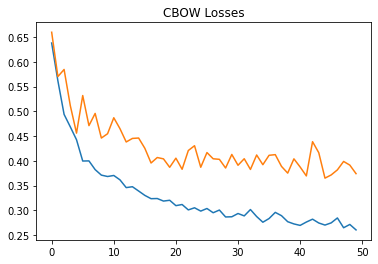

In [ ]:
## Simple Plotting Utility
def showPlot(title, *args):
    plt.figure()
    fig, ax = plt.subplots()
    for a in args:
      _ = ax.plot(a)
    _ = ax.set_title(title)
    
showPlot('CBOW Losses',train_losses,val_losses)



In [ ]:

torch.save(best_model,'/content/gdrive/My Drive/3dunet-supervised-all-modalities.pt')

In [ ]:
model = torch.load('/content/gdrive/My Drive/3dunet-supervised-all-modalities.pt')

In [ ]:
import time
start_time = time.time()
dice_score_dataset(model, test_loader, n_classes)
print("--- %s seconds ---" % (time.time() - start_time))


0.4981295628592747

In [ ]:
import time
start_time = time.time()
dice_score_dataset(model, test_loader, n_classes)
print("--- %s seconds ---" % (time.time() - start_time))

--- 24.888115644454956 seconds ---


Device cuda
torch.Size([1, 64, 64, 32])
MRI Input


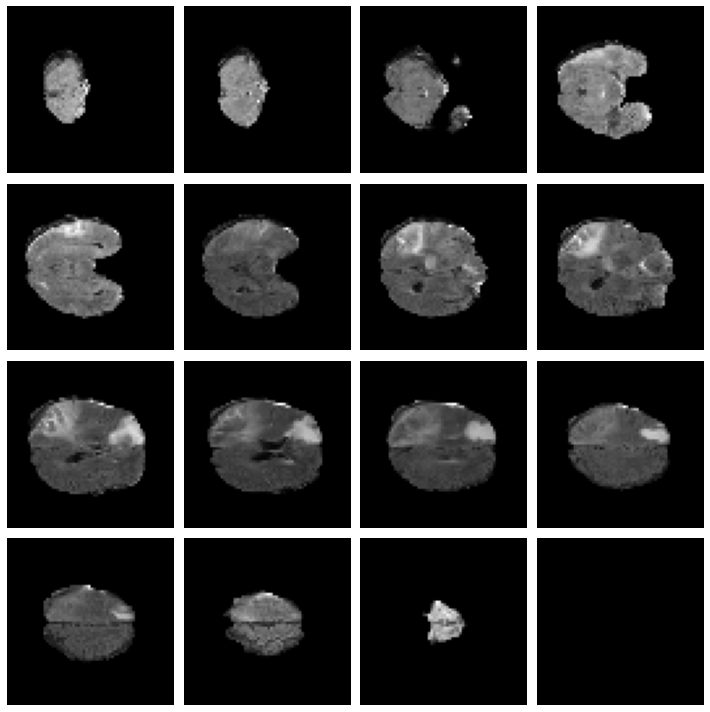

Ground truth


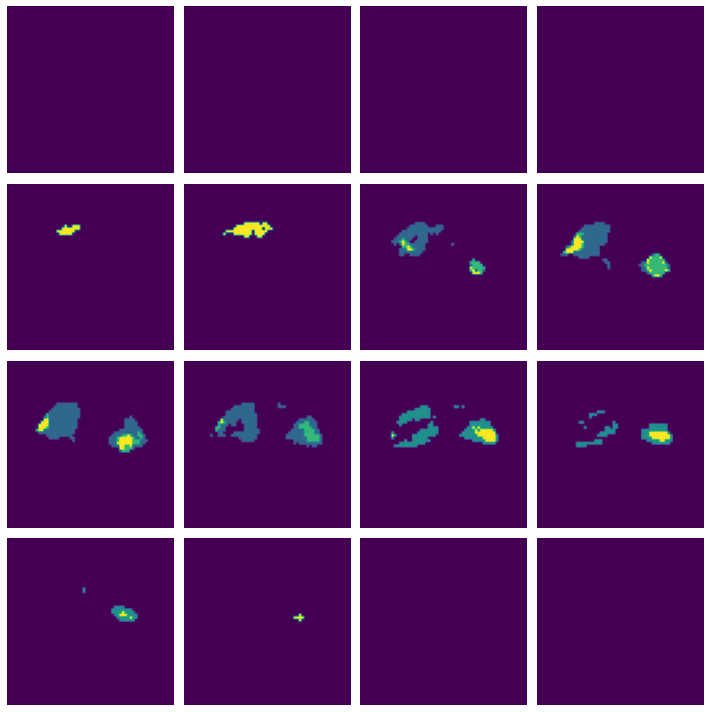

Predicted segmentation


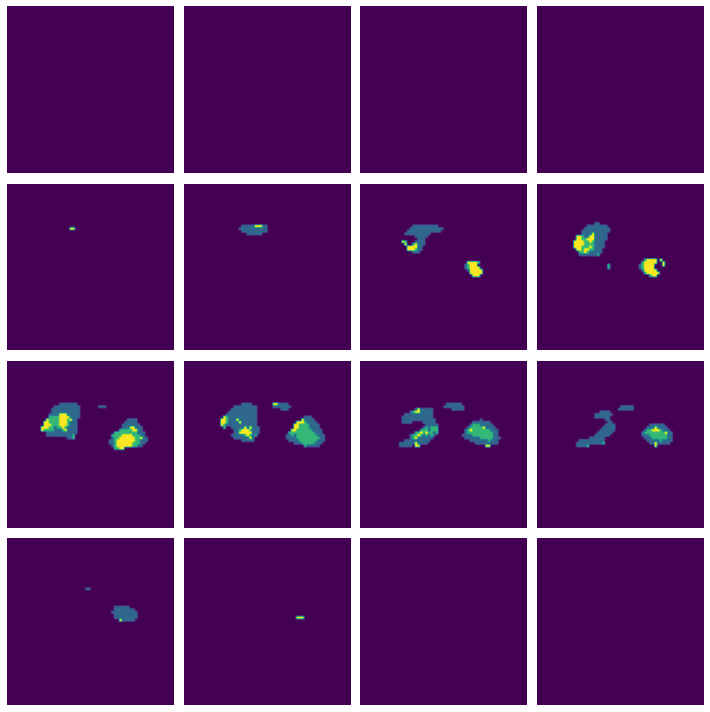

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

use_gpu=True
cuda0 = torch.device('cuda:0')
n_classes=4

model.eval()
slide = 17
for j,batch in enumerate(test_loader):
    if j == 5:
        

        inputs, targets = batch["img"], batch["seg"] # size of [B, Slice, H, W]

        # use only flair
        #inputs = inputs[:,0,:,:,:]
        #inputs = torch.unsqueeze(inputs,dim=1)

        inputs = inputs.permute(0,1,4,2,3)

            
        if use_gpu:
            inputs = inputs.to(device)
            targets = targets.to(device)
                
        #making predictions
        y_pred = model(inputs)
        y_pred = torch.argmax(y_pred, dim = 1) 
        y_pred = y_pred.permute(0,2,3,1).cpu().detach().numpy()
        targets = torch.argmax(targets, dim = 1).cpu()
        print(targets.shape)
        #y_pred=y_pred.unsqueeze(dim=1)
        #y_pred = make_one_hot(y_pred, n_classes) # at this point pseudolabels matches input size
        #print(y_pred.shape)

        #y_pred = y_pred.permute(0,1,3,4,2).cpu().detach().numpy()

        print('MRI Input')
        fig, axs = plt.subplots(4, 4, figsize=[10, 10])
        
        counter = 0
        for slide in range(16):
            slide*=2
            axs.flat[counter].imshow(batch["img"][0,0,...,slide],cmap='gray')
            axs.flat[counter].axis('off')
            counter+=1
                
        plt.tight_layout()
        plt.show()

        print('Ground truth')
        fig, axs = plt.subplots(4, 4, figsize=[10, 10])
        counter = 0
        for slide in range(16):
            slide*=2
            axs.flat[counter].imshow(targets[0,...,slide])
            axs.flat[counter].axis('off')
            counter+=1
                
        plt.tight_layout()
        plt.show()

        print('Predicted segmentation')
        fig, axs = plt.subplots(4, 4, figsize=[10, 10])
        counter = 0
        for slide in range(16):
            slide*=2
            axs.flat[counter].imshow(y_pred[0,...,slide])
            axs.flat[counter].axis('off')
            counter+=1
                
        plt.tight_layout()
        plt.show()


        '''
        # visualize different modality
        plt.subplots(1, 4, figsize = (30,4))
        plt.subplot(1,4, 1);plt.imshow(batch["img"][0,0,...,slide])
        plt.subplot(1,4, 2);plt.imshow(batch["img"][0,1,...,slide])
        plt.subplot(1,4, 3);plt.imshow(batch["img"][0,2,...,slide])
        plt.subplot(1,4, 4);plt.imshow(batch["img"][0,3,...,slide])

        # visualize true label
        plt.subplots(1, 4, figsize = (30,4))
        plt.subplot(1,4, 1);plt.imshow(batch["seg"][0,0,...,slide])
        plt.subplot(1,4, 2);plt.imshow(batch["seg"][0,1,...,slide])
        plt.subplot(1,4, 3);plt.imshow(batch["seg"][0,2,...,slide])
        plt.subplot(1,4, 4);plt.imshow(batch["seg"][0,3,...,slide])

        # visualize prediction
        plt.subplots(1, 4, figsize = (30,4))
        plt.subplot(1,4, 1);plt.imshow(y_pred[0,0,...,slide])
        plt.subplot(1,4, 2);plt.imshow(y_pred[0,1,...,slide])
        plt.subplot(1,4, 3);plt.imshow(y_pred[0,2,...,slide])
        plt.subplot(1,4, 4);plt.imshow(y_pred[0,3,...,slide])

        fig = plt.figure()
        ax = plt.axes(projection='3d')
        '''
        break




## Unsupervised 3D-Unet from scratch

In [ ]:
def dice_score_image(prediction, target, n_classes):
    '''
      computer the mean dice score for a single image

      Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
      Args:
          prediction (tensor): predictied labels of the image
          target (tensor): ground truth of the image
          n_classes (int): number of classes
    
      Returns:
          m_dice (float): Mean dice score over classes
    '''

    
    dice_classes = np.zeros(n_classes)
    
    pred_flat = prediction.contiguous().view(-1)
    target_flat = target.contiguous().view(-1)
    for cl in range(n_classes):
        TP = ((pred_flat == cl) * (target_flat == cl)).sum().item()
        FP = ((pred_flat == cl) * (target_flat != cl)).sum().item()
        FN = ((pred_flat != cl) * (target_flat == cl)).sum().item()

        

        #When there is no grount truth of the class in this image
        #Give 1 dice score if False Positive pixel number is 0, 
        #give 0 dice score if False Positive pixel number is not 0 (> 0).
        if not (target_flat == cl).any():
            dice_classes[cl] = 1 if FP == 0 else 0
        else:
            dice_classes[cl] = (2 * TP) / (2 * TP + FP + FN)
    return dice_classes.mean()

def dice_score_dataset(model, dataloader, num_classes, use_gpu=True):
    """
    Compute the mean dice score on a set of data.
    
    Note that multiclass dice score can be defined as the mean over classes of binary
    dice score. Dice score is computed per image. Mean dice score over the dataset is the dice
    score averaged across all images.
    
    Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
     
    Args:
        model (UNET class): Your trained model
        dataloader (DataLoader): Dataset for evaluation
        num_classes (int): Number of classes
    
    Returns:
        m_dice (float): Mean dice score over the input dataset
    """
    ## Number of Batches and Cache over Dataset 
    n_batches = len(dataloader)
    scores = np.zeros(n_batches)
    ## Evaluate
    model.eval()
    idx = 0
    for data in dataloader:
        ## Format Data
        img, target = data["img"], data["seg"]

        # use only flair
        #img = img[:,0,:,:,:]
        #img = torch.unsqueeze(img,dim=1)

        img = img.permute(0,1,4,2,3)
        target = target.permute(0,1,4,2,3)

        if use_gpu:
            img = img.cuda()
            target = target.cuda()
        ## Make Predictions
        y_pred = model(img)
        #out = functional.softmax(out, dim=1)
        n_classes = y_pred.shape[1]
        images_per_batch = y_pred.shape[0]

        kmeans_input_3d = y_pred[0,:,:,:,:].cpu().detach().numpy().reshape(n_classes,32*64*64)
        kmeans_input_3d=np.transpose(kmeans_input_3d)
        kmeans = KMeans(n_clusters=n_classes, random_state=0).fit(kmeans_input_3d) 
        pseudolabels = kmeans.labels_

        pseudolabels = np.asarray(pseudolabels)
        
        # align the pseudolabels to be comparable with true labels
        count_0=sum(pseudolabels.flatten() == 0)
        count_1=sum(pseudolabels.flatten() == 1)
        count_2=sum(pseudolabels.flatten() == 2)
        count_3=sum(pseudolabels.flatten() == 3)
        count_4=sum(pseudolabels.flatten() == 4)
        count_dict={0:count_0, 1:count_1, 2:count_2, 3:count_3, 4:count_4}
        sorted_count_dict = dict( sorted(count_dict.items(), key=operator.itemgetter(1),reverse=True))

        new_pseudolabels=np.empty([pseudolabels.shape[0]])
        classes = [0,1,2,3,4]
        counter = 0
        for label_sorted in sorted_count_dict.keys():
            new_pseudolabels[pseudolabels == label_sorted] = classes[counter]
            counter+=1
        
        
        new_pseudolabels2=new_pseudolabels.reshape(y_pred.shape[2], 64, 64)
        new_pseudolabels2 = torch.tensor(new_pseudolabels2)
        new_pseudolabels2=new_pseudolabels2.unsqueeze(dim=0).cuda() # add first dimension, i.e. batch size (assume batch size = 1)

        # one-hot encoding
        new_pseudolabels_one_hot=new_pseudolabels2.unsqueeze(dim=1)
        new_pseudolabels_one_hot = make_one_hot(new_pseudolabels_one_hot, n_classes) # at this point pseudolabels matches input size
        
        
        prediction = torch.argmax(new_pseudolabels_one_hot, dim = 1) 
        target = torch.argmax(target, dim = 1)
        mean_score_per_batch=[]
        for image in range(images_per_batch):  
            mean_score_per_batch = dice_score_image(prediction[image,:,:,:], target[image,:,:,:], n_classes)
        
        scores[idx] = np.mean(mean_score_per_batch)
        idx += 1
    ## Average Dice Score Over Images
    m_dice = scores.mean()
    return m_dice


In [ ]:
def evaluate_model(dl, model, loss):

    losses=[]
    model.eval()
    for j, batch in enumerate(dl):
        inputs, targets = batch["img"], batch["seg"] # size of [B, Slice, H, W]
        
        # use only flair
        #inputs = inputs[:,0,:,:,:]
        #inputs = torch.unsqueeze(inputs,dim=1)

        inputs = inputs.permute(0,1,4,2,3)
        targets = targets.permute(0,1,4,2,3)
        
        if use_gpu:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
      
        #making predictions
        y_pred = model(inputs)

        n_classes = y_pred.shape[1]
        images_per_batch = y_pred.shape[0]

        kmeans_input_3d = y_pred[0,:,:,:,:].cpu().detach().numpy().reshape(n_classes,32*64*64)
        kmeans_input_3d=np.transpose(kmeans_input_3d)
        kmeans = KMeans(n_clusters=n_classes, random_state=0).fit(kmeans_input_3d) 
        pseudolabels = kmeans.labels_

        pseudolabels = np.asarray(pseudolabels)
        
        # align the pseudolabels to be comparable with true labels
        count_0=sum(pseudolabels.flatten() == 0)
        count_1=sum(pseudolabels.flatten() == 1)
        count_2=sum(pseudolabels.flatten() == 2)
        count_3=sum(pseudolabels.flatten() == 3)
        count_4=sum(pseudolabels.flatten() == 4)
        count_dict={0:count_0, 1:count_1, 2:count_2, 3:count_3, 4:count_4}
        sorted_count_dict = dict( sorted(count_dict.items(), key=operator.itemgetter(1),reverse=True))

        new_pseudolabels=np.empty([pseudolabels.shape[0]])
        classes = [0,1,2,3,4]
        counter = 0
        for label_sorted in sorted_count_dict.keys():
            new_pseudolabels[pseudolabels == label_sorted] = classes[counter]
            counter+=1
        
        
        new_pseudolabels2=new_pseudolabels.reshape(y_pred.shape[2], 64, 64)
        new_pseudolabels2 = torch.tensor(new_pseudolabels2)
        new_pseudolabels2=new_pseudolabels2.unsqueeze(dim=0).cuda() # add first dimension, i.e. batch size (assume batch size = 1)

        # one-hot encoding
        new_pseudolabels_one_hot=new_pseudolabels2.unsqueeze(dim=1)
        new_pseudolabels_one_hot = make_one_hot(new_pseudolabels_one_hot, n_classes) # at this point pseudolabels matches input size
        
        
        #calculating loss
        model_loss = loss(y_pred,new_pseudolabels_one_hot)
        
        losses.append(model_loss.item())

    return np.mean(losses)

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import operator

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

use_gpu=True
cuda0 = torch.device('cuda:0')

## Initialize your unet
n_classes = 5
model = UNET_3D(n_classes)
model.apply(initialize_weights)

learning_rate=0.00005

## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

print("Start Training...")

train_losses=[]
val_losses=[]
loss=DICELoss()
early_stopping=False
min_val=1000
num_epoch_converge=0

if use_gpu:
    model.to(device)
for epoch in range(10):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    
    
    # TODO: Design your own training section
    loss_per_epoch=[]
    for j,batch in enumerate(train_loader):
        
        inputs, targets = batch["img"], batch["seg"] # size of [B, Slice, H, W]
        inputs = inputs.permute(0,1,4,2,3)
        targets = targets.permute(0,1,4,2,3)

        if use_gpu:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
        
        model.train()

        #making predictions
        y_pred = model(inputs)
        

        

        '''
        y_pred_visualize=y_pred_visualize.unsqueeze(dim=1)
        y_pred_visualize = make_one_hot(y_pred_visualize, n_classes) 

        y_pred_visualize = y_pred_visualize.permute(0,1,3,4,2).cpu().detach().numpy()

        # visualize different modality

        slide = 16    
        plt.subplots(1, 4, figsize = (30,4))
        plt.subplot(1,4, 1);plt.imshow(batch["img"][0,0,...,slide])
        plt.subplot(1,4, 2);plt.imshow(batch["img"][0,1,...,slide])
        plt.subplot(1,4, 3);plt.imshow(batch["img"][0,2,...,slide])
        plt.subplot(1,4, 4);plt.imshow(batch["img"][0,3,...,slide])

        # visualize true label
        plt.subplots(1, 4, figsize = (30,4))
        plt.subplot(1,4, 1);plt.imshow(batch["seg"][0,0,...,slide])
        plt.subplot(1,4, 2);plt.imshow(batch["seg"][0,1,...,slide])
        plt.subplot(1,4, 3);plt.imshow(batch["seg"][0,2,...,slide])
        plt.subplot(1,4, 4);plt.imshow(batch["seg"][0,3,...,slide])

        # visualize prediction
        plt.subplots(1, 10, figsize = (30,10))
        plt.subplot(1,10, 1);plt.imshow(y_pred_visualize[0,0,...,slide])
        plt.subplot(1,10, 2);plt.imshow(y_pred_visualize[0,1,...,slide])
        plt.subplot(1,10, 3);plt.imshow(y_pred_visualize[0,2,...,slide])
        plt.subplot(1,10, 4);plt.imshow(y_pred_visualize[0,3,...,slide])
        plt.subplot(1,10, 5);plt.imshow(y_pred_visualize[0,4,...,slide])
        plt.subplot(1,10, 6);plt.imshow(y_pred_visualize[0,5,...,slide])
        plt.subplot(1,10, 7);plt.imshow(y_pred_visualize[0,6,...,slide])
        plt.subplot(1,10, 8);plt.imshow(y_pred_visualize[0,7,...,slide])
        plt.subplot(1,10, 9);plt.imshow(y_pred_visualize[0,8,...,slide])
        plt.subplot(1,10, 10);plt.imshow(y_pred_visualize[0,9,...,slide])
        '''



        #y_pred_argmax = torch.argmax(y_pred, dim = 1) 
        #print(y_pred_argmax.shape)

        kmeans_input_3d = y_pred[0,:,:,:,:].cpu().detach().numpy().reshape(n_classes,32*64*64)
        kmeans_input_3d=np.transpose(kmeans_input_3d)
        print('kmeans_input_3d',kmeans_input_3d.shape)
        kmeans = KMeans(n_clusters=n_classes, random_state=0).fit(kmeans_input_3d) 
        pseudolabels = kmeans.labels_

        '''

        for i in range(y_pred.shape[2]):
            y_pred_slide=y_pred[0,:,i,:,:]
            #print(y_pred_slide.shape)

            # clustering on pixel-level to generate pseudolabels
            kmeans_input=y_pred_slide.cpu().detach().numpy().reshape(n_classes,64*64)
            kmeans_input=np.transpose(kmeans_input)

            #cluster = KMeans(n_clusters=n_classes)
            #cluster = sorted_cluster(kmeans_input, cluster)

            #print('kmeans_input',kmeans_input.shape)
            kmeans = KMeans(n_clusters=n_classes, random_state=0).fit(kmeans_input) 
            #print(kmeans.labels_.shape)
            pseudolabels.append(kmeans.labels_)
        '''
        pseudolabels = np.asarray(pseudolabels)
        print('pseudolabels',pseudolabels.shape)
        
        # align the pseudolabels to be comparable with true labels
        count_0=sum(pseudolabels.flatten() == 0)
        count_1=sum(pseudolabels.flatten() == 1)
        count_2=sum(pseudolabels.flatten() == 2)
        count_3=sum(pseudolabels.flatten() == 3)
        count_4=sum(pseudolabels.flatten() == 4)
        count_dict={0:count_0, 1:count_1, 2:count_2, 3:count_3, 4:count_4}
        print('count_dict',count_dict)
        sorted_count_dict = dict( sorted(count_dict.items(), key=operator.itemgetter(1),reverse=True))

        new_pseudolabels=np.empty([pseudolabels.shape[0]])
        classes = [0,1,2,3,4]
        counter = 0
        print('sorted_count_dict.keys()',sorted_count_dict.keys())
        for label_sorted in sorted_count_dict.keys():
            new_pseudolabels[pseudolabels == label_sorted] = classes[counter]
            counter+=1
        #print('new pseudolabels',new_pseudolabels)
        #print('pseudolabels',pseudolabels.shape)
        
        
        new_pseudolabels2=new_pseudolabels.reshape(y_pred.shape[2], 64, 64)
        new_pseudolabels2 = torch.tensor(new_pseudolabels2)
        new_pseudolabels2=new_pseudolabels2.unsqueeze(dim=0).cuda() # add first dimension, i.e. batch size (assume batch size = 1)

        # one-hot encoding
        new_pseudolabels_one_hot=new_pseudolabels2.unsqueeze(dim=1)
        new_pseudolabels_one_hot = make_one_hot(new_pseudolabels_one_hot, n_classes) # at this point pseudolabels matches input size
        #print('pseudolabels tensor',pseudolabels.shape)

        model_loss = loss(y_pred,new_pseudolabels_one_hot)

        #backprop
        optimizer.zero_grad()
        model_loss.backward()
        optimizer.step()

        loss_per_epoch.append(model_loss.item())

        print('loss_per_batch:',model_loss.item())

        # visualize
        slide = 16
        count_0=sum(new_pseudolabels.flatten() == 0)
        count_1=sum(new_pseudolabels.flatten() == 1)
        count_2=sum(new_pseudolabels.flatten() == 2)
        count_3=sum(new_pseudolabels.flatten() == 3)
        count_4=sum(new_pseudolabels.flatten() == 4)
        count_dict={0:count_0, 1:count_1, 2:count_2, 3:count_3, 4:count_4}
        print('count_dict',count_dict)
        sorted_count_dict = dict( sorted(count_dict.items(), key=operator.itemgetter(1),reverse=True))

        new_pseudolabels_visualize=np.empty([new_pseudolabels.shape[0]])
        counter = 0
        print('sorted_count_dict.keys()',sorted_count_dict.keys())
        for label_sorted in sorted_count_dict.keys():
            if counter < 4:
                new_pseudolabels_visualize[new_pseudolabels == label_sorted] = 0
            else:
                new_pseudolabels_visualize[new_pseudolabels == label_sorted] = 1
            counter+=1

        new_pseudolabels_visualize=new_pseudolabels_visualize.reshape(y_pred.shape[2], 64, 64)
        new_pseudolabels_visualize = torch.tensor(new_pseudolabels_visualize)
        new_pseudolabels_visualize=new_pseudolabels_visualize.unsqueeze(dim=0).cuda() # add first dimension, i.e. batch size (assume batch size = 1)

        new_pseudolabels_visualize = new_pseudolabels_visualize.permute(0,2,3,1).cpu().detach().numpy()
        new_pseudolabels2 = new_pseudolabels2.permute(0,2,3,1).cpu().detach().numpy()

        plt.subplots(1, 4, figsize = (30,4))
        plt.subplot(1,4, 1);plt.imshow(batch["img"][0,0,...,slide])
        plt.subplot(1,4, 2);plt.imshow(batch["img"][0,1,...,slide])
        plt.subplot(1,4, 3);plt.imshow(batch["img"][0,2,...,slide])
        plt.subplot(1,4, 4);plt.imshow(batch["img"][0,3,...,slide])
            
        plt.subplots(1, 2, figsize = (30,4))
        plt.subplot(1,2, 1);plt.imshow(new_pseudolabels_visualize[0,...,slide])
        plt.subplot(1,2, 2);plt.imshow(new_pseudolabels2[0,...,slide])
        plt.tight_layout()
        plt.show()



    # evaluate unsupervised segmentation to true label
    '''
    y_pred_argmax = torch.argmax(y_pred, dim=1)
    targets_argmax = torch.argmax(targets, dim=1)
    print('y_pred_argmax',y_pred_argmax.shape)
    print('new_pseudolabels',new_pseudolabels.shape)
    mean_score_per_batch = dice_score_image(y_pred_argmax, new_pseudolabels, n_classes) # assume batch size = 1
    dice_score_true_label = dice_score_image(new_pseudolabels, targets_argmax, n_classes)
    '''


    print("epoch {0:3d}\tTraining loss: {1:6.3f}".format(epoch+1,np.mean(loss_per_epoch)))

    

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import operator

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

use_gpu=True
cuda0 = torch.device('cuda:0')

## Initialize your unet
n_classes = 5
model = UNET_3D(n_classes)
model.apply(initialize_weights)

learning_rate=0.00005

## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print("Start Training...")

train_losses=[]
val_losses=[]
train_dice=[]
val_dice=[]
loss=DICELoss()
early_stopping=False
min_val=1000
num_epoch_converge=0

min_val_loss = 1000

num_epochs = 50
if use_gpu:
    model.to(device)
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    
    
    # TODO: Design your own training section
    loss_per_epoch=[]
    for j,batch in enumerate(train_loader):
        
        inputs, targets = batch["img"], batch["seg"] # size of [B, Slice, H, W]
        inputs = inputs.permute(0,1,4,2,3)
        targets = targets.permute(0,1,4,2,3)

        if use_gpu:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
        
        model.train()

        #making predictions
        y_pred = model(inputs)
        


        #y_pred_argmax = torch.argmax(y_pred, dim = 1) 
        #print(y_pred_argmax.shape)

        kmeans_input_3d = y_pred[0,:,:,:,:].cpu().detach().numpy().reshape(n_classes,32*64*64)
        kmeans_input_3d=np.transpose(kmeans_input_3d)
        kmeans = KMeans(n_clusters=n_classes, random_state=0).fit(kmeans_input_3d) 
        pseudolabels = kmeans.labels_


        pseudolabels = np.asarray(pseudolabels)
        
        # align the pseudolabels to be comparable with true labels
        count_0=sum(pseudolabels.flatten() == 0)
        count_1=sum(pseudolabels.flatten() == 1)
        count_2=sum(pseudolabels.flatten() == 2)
        count_3=sum(pseudolabels.flatten() == 3)
        count_4=sum(pseudolabels.flatten() == 4)
        count_dict={0:count_0, 1:count_1, 2:count_2, 3:count_3, 4:count_4}
        sorted_count_dict = dict( sorted(count_dict.items(), key=operator.itemgetter(1),reverse=True))

        new_pseudolabels=np.empty([pseudolabels.shape[0]])
        classes = [0,1,2,3,4]
        counter = 0
        for label_sorted in sorted_count_dict.keys():
            new_pseudolabels[pseudolabels == label_sorted] = classes[counter]
            counter+=1
        #print('new pseudolabels',new_pseudolabels)
        #print('pseudolabels',pseudolabels.shape)
        
        
        new_pseudolabels2=new_pseudolabels.reshape(y_pred.shape[2], 64, 64)
        new_pseudolabels2 = torch.tensor(new_pseudolabels2)
        new_pseudolabels2=new_pseudolabels2.unsqueeze(dim=0).cuda() # add first dimension, i.e. batch size (assume batch size = 1)

        # one-hot encoding
        new_pseudolabels_one_hot=new_pseudolabels2.unsqueeze(dim=1)
        new_pseudolabels_one_hot = make_one_hot(new_pseudolabels_one_hot, n_classes) # at this point pseudolabels matches input size
        #print('pseudolabels tensor',pseudolabels.shape)

        model_loss = loss(y_pred,new_pseudolabels_one_hot)

        #backprop
        optimizer.zero_grad()
        model_loss.backward()
        optimizer.step()

        loss_per_epoch.append(model_loss.item())

        #print('loss_per_batch:',model_loss.item())

    scheduler.step()



    # evaluate unsupervised segmentation to true label
    train_losses.append(np.mean(loss_per_epoch))

    val_loss=evaluate_model(val_loader,model,loss)
    val_losses.append(val_loss)

    #train_dice_score = dice_score_dataset(model, train_loader, n_classes) 
    #val_dice_score = dice_score_dataset(model, val_loader, n_classes)

    #train_dice.append(train_dice_score)
    #val_dice.append(val_dice_score)

    if val_loss < min_val_loss:
        best_model = model
        min_val_loss = val_loss
    

    print("epoch {0:3d}\tTraining loss: {1:6.3f}\tVal loss: {2:6.3f}".format(epoch+1,np.mean(loss_per_epoch), val_loss))
    

Device cuda
Start Training...

EPOCH 1 of 50

epoch   1	Training loss:  0.597	Val loss:  0.564

EPOCH 2 of 50

epoch   2	Training loss:  0.320	Val loss:  0.179

EPOCH 3 of 50

epoch   3	Training loss:  0.091	Val loss:  0.125

EPOCH 4 of 50

epoch   4	Training loss:  0.301	Val loss:  0.444

EPOCH 5 of 50

epoch   5	Training loss:  0.253	Val loss:  0.689

EPOCH 6 of 50

epoch   6	Training loss:  0.286	Val loss:  0.251

EPOCH 7 of 50

epoch   7	Training loss:  0.289	Val loss:  0.618

EPOCH 8 of 50

epoch   8	Training loss:  0.553	Val loss:  0.481

EPOCH 9 of 50

epoch   9	Training loss:  0.164	Val loss:  0.071

EPOCH 10 of 50

epoch  10	Training loss:  0.094	Val loss:  0.112

EPOCH 11 of 50

epoch  11	Training loss:  0.156	Val loss:  0.185

EPOCH 12 of 50

epoch  12	Training loss:  0.154	Val loss:  0.273

EPOCH 13 of 50

epoch  13	Training loss:  0.165	Val loss:  0.254

EPOCH 14 of 50

epoch  14	Training loss:  0.190	Val loss:  0.267

EPOCH 15 of 50

epoch  15	Training loss:  0.171	Val lo

<Figure size 432x288 with 0 Axes>

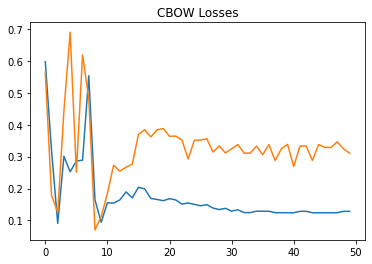

In [ ]:
## Simple Plotting Utility
def showPlot(title, *args):
    plt.figure()
    fig, ax = plt.subplots()
    for a in args:
      _ = ax.plot(a)
    _ = ax.set_title(title)
    
showPlot('CBOW Losses',train_losses,val_losses)

torch.save(best_model,'/content/gdrive/My Drive/3dunet-unsupervised-all-modalities.pt')

In [ ]:
model=torch.load('/content/gdrive/My Drive/3dunet-unsupervised-all-modalities.pt')
from sklearn.cluster import KMeans
import numpy as np
import operator

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

use_gpu=True
cuda0 = torch.device('cuda:0')

## Initialize your unet
n_classes = 5

learning_rate=0.00005

## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


Device cuda


In [ ]:
dice_score_dataset(model, val_loader, n_classes)

0.09848812172713314

In [ ]:
dice_score_dataset(model, test_loader, n_classes)

0.09552608544881123

In [ ]:
import time
start_time = time.time()
dice_score_dataset(model, test_loader, n_classes)
print("--- %s seconds ---" % (time.time() - start_time))

--- 51.67942810058594 seconds ---


Device cuda


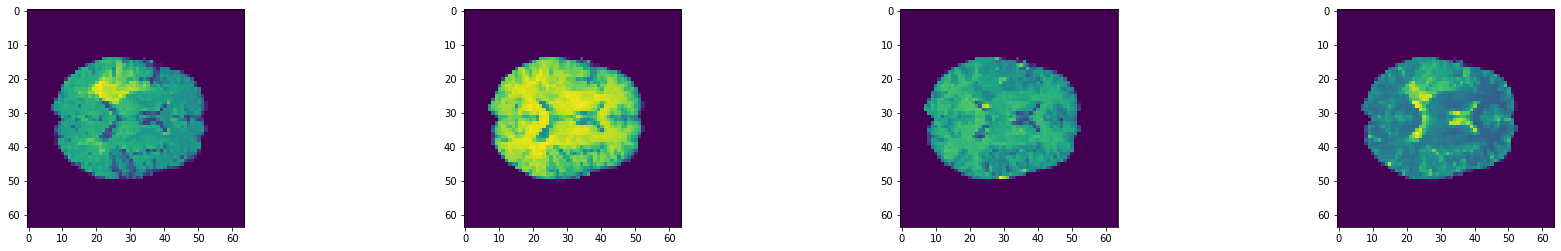

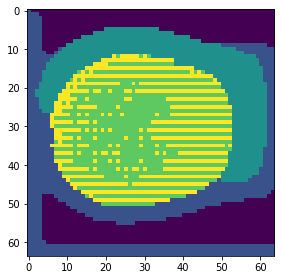

Ground truth


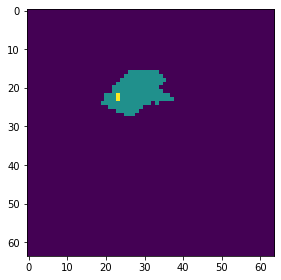

<Figure size 432x288 with 0 Axes>

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

use_gpu=True
cuda0 = torch.device('cuda:0')
n_classes=5

model.eval()
slide = 17
for j,batch in enumerate(test_loader):
    if j == 2:
      
        inputs, targets = batch["img"], batch["seg"] # size of [B, Slice, H, W]
        inputs = inputs.permute(0,1,4,2,3)
        targets = targets.permute(0,1,4,2,3)

        if use_gpu:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
        
        #making predictions
        y_pred = model(inputs)
        


        #y_pred_argmax = torch.argmax(y_pred, dim = 1) 
        #print(y_pred_argmax.shape)

        kmeans_input_3d = y_pred[0,:,:,:,:].cpu().detach().numpy().reshape(n_classes,32*64*64)
        kmeans_input_3d=np.transpose(kmeans_input_3d)
        kmeans = KMeans(n_clusters=n_classes, random_state=0).fit(kmeans_input_3d) 
        pseudolabels = kmeans.labels_


        pseudolabels = np.asarray(pseudolabels)
        
        # align the pseudolabels to be comparable with true labels
        count_0=sum(pseudolabels.flatten() == 0)
        count_1=sum(pseudolabels.flatten() == 1)
        count_2=sum(pseudolabels.flatten() == 2)
        count_3=sum(pseudolabels.flatten() == 3)
        count_4=sum(pseudolabels.flatten() == 4)
        count_dict={0:count_0, 1:count_1, 2:count_2, 3:count_3, 4:count_4}
        sorted_count_dict = dict( sorted(count_dict.items(), key=operator.itemgetter(1),reverse=True))

        new_pseudolabels=np.empty([pseudolabels.shape[0]])
        classes = [0,1,2,3,4]
        counter = 0
        for label_sorted in sorted_count_dict.keys():
            new_pseudolabels[pseudolabels == label_sorted] = classes[counter]
            counter+=1
        #print('new pseudolabels',new_pseudolabels)
        #print('pseudolabels',pseudolabels.shape)
        
        
        new_pseudolabels2=new_pseudolabels.reshape(y_pred.shape[2], 64, 64)
        new_pseudolabels2 = torch.tensor(new_pseudolabels2)
        new_pseudolabels2=new_pseudolabels2.unsqueeze(dim=0).cuda() # add first dimension, i.e. batch size (assume batch size = 1)

        

        
        # visualize
        slide = 16
        new_pseudolabels_visualize = new_pseudolabels2.permute(0,2,3,1).cpu().detach().numpy()
        inputs_visualize = inputs.permute(0,1,3,4,2).cpu().detach().numpy()

        plt.subplots(1, 4, figsize = (30,4))
        plt.subplot(1,4, 1);plt.imshow(inputs_visualize[0,0,...,slide])
        plt.subplot(1,4, 2);plt.imshow(inputs_visualize[0,1,...,slide])
        plt.subplot(1,4, 3);plt.imshow(inputs_visualize[0,2,...,slide])
        plt.subplot(1,4, 4);plt.imshow(inputs_visualize[0,3,...,slide])


        plt.subplots(1, 1, figsize = (30,4))
        plt.subplot(1,1, 1);plt.imshow(new_pseudolabels_visualize[0,...,slide])
        plt.tight_layout()
        plt.show()


        targets = torch.argmax(targets, dim = 1).cpu()
        targets = targets.permute(0,2,3,1)

        print('Ground truth')
        plt.subplots(1, 1, figsize = (30,4))
        plt.subplot(1,1, 1);plt.imshow(targets[0,...,slide])
        plt.tight_layout()
        plt.show()
                
        plt.tight_layout()
        plt.show()
 
        break


## KMeans Pre-training

In [ ]:
from torch.nn.modules.activation import Softmax
## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding=1,
                   bias=True,
                   useBN=True):
    """
    
    """
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm3d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv3d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm3d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv3d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )

## Upsampling
def upsample(ch_coarse,
             ch_fine):
    """
    
    """
    return nn.Sequential(
                    nn.ConvTranspose3d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
                    nn.ReLU())

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        return self.softmax(self.conv(x))


# U-Net
class UNET_3D(nn.Module):
    
    """
    
    """
    def __init__(self,n_classes, useBN=True):
        """
        Args:
            useBN (bool): Turn Batch Norm on or off
        """
        super(UNET_3D, self).__init__()
        # Downgrade stages
        self.conv1 = add_conv_stage(5, 32, useBN=useBN)
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool3d(2)
        # Upsample layers
        self.upsample43 = upsample(256, 128)
        self.upsample32 = upsample(128,  64)
        self.upsample21 = upsample(64 ,  32)

        #TODO: Design your last layer & activations
        self.outc = OutConv(32, n_classes)

        


    def forward(self, x):
        """
        Forward pass
        """
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))

        conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)

        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)

        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)
        
        out = self.outc(conv1m_out)    

        return out

In [ ]:
def evaluate_model_pretraining(dl, model, loss):

    losses=[]
    model.eval()
    for j, batch in enumerate(dl):
        inputs, targets = batch["img"], batch["seg"] # size of [B, Slice, H, W]

        # use only flair
        #inputs = inputs[:,0,:,:,:]
        #inputs = torch.unsqueeze(inputs,dim=1)

        inputs = inputs.permute(0,1,4,2,3)
        targets = targets.permute(0,1,4,2,3)

        #print('inputs',inputs.shape)

        
        # kmeans pre-training
        kmeans_input_3d = inputs[0,:,:,:,:].cpu().detach().numpy().reshape(4,32*64*64) # 4 modalities
        kmeans_input_3d=np.transpose(kmeans_input_3d)
        #print('kmeans_input_3d',kmeans_input_3d.shape)
        kmeans = KMeans(n_clusters=5, random_state=0).fit(kmeans_input_3d) 
        pseudolabels = kmeans.labels_

        
        pseudolabels = np.asarray(pseudolabels)
        #print('pseudolabels',pseudolabels.shape)
        
        # align the pseudolabels to be comparable with true labels
        count_0=sum(pseudolabels.flatten() == 0)
        count_1=sum(pseudolabels.flatten() == 1)
        count_2=sum(pseudolabels.flatten() == 2)
        count_3=sum(pseudolabels.flatten() == 3)
        count_4=sum(pseudolabels.flatten() == 4)
        count_dict={0:count_0, 1:count_1, 2:count_2, 3:count_3, 4:count_4}
        #print('count_dict',count_dict)
        sorted_count_dict = dict( sorted(count_dict.items(), key=operator.itemgetter(1),reverse=True))

        new_pseudolabels=np.empty([pseudolabels.shape[0]])
        classes = [0,1,2,3,4]
        counter = 0
        #print('sorted_count_dict.keys()',sorted_count_dict.keys())
        for label_sorted in sorted_count_dict.keys():
            new_pseudolabels[pseudolabels == label_sorted] = classes[counter]
            counter+=1
        #print('new pseudolabels',new_pseudolabels)
        #print('pseudolabels',pseudolabels.shape)
        
        
        
        new_pseudolabels=new_pseudolabels.reshape(inputs.shape[2], 64, 64)
        new_pseudolabels = torch.tensor(new_pseudolabels)
        new_pseudolabels=new_pseudolabels.unsqueeze(dim=0).cuda() # add first dimension, i.e. batch size (assume batch size = 1)

        new_pseudolabels_one_hot=new_pseudolabels.unsqueeze(dim=1)
        new_pseudolabels_one_hot = make_one_hot(new_pseudolabels_one_hot, 5) 
        #print('new_pseudolabels_one_hot',new_pseudolabels_one_hot.shape)

        if use_gpu:
            inputs = inputs.to(device)
            targets = targets.to(device)
            new_pseudolabels_one_hot = new_pseudolabels_one_hot.to(device)
    
        
        model.eval()

        #making predictions
        #y_pred = model(new_pseudolabels_one_hot.float())
        y_pred = model(new_pseudolabels_one_hot)
        #print('y_pred',y_pred.shape)

        #calculating loss
        model_loss = loss(y_pred,targets)
        
        losses.append(model_loss.item())

    return np.mean(losses)

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import operator
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

use_gpu=True
cuda0 = torch.device('cuda:0')

## Initialize your unet
n_classes = 4
model = UNET_3D(n_classes)
model.apply(initialize_weights)


## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

print("Start Training...")

train_losses=[]
val_losses=[]
loss=DICELoss()
early_stopping=False
min_val=1000
num_epoch_converge=0
num_epochs=50

min_val_loss=1000

if use_gpu:
    model.to(device)
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    
    
    # TODO: Design your own training section
    loss_per_epoch=[]
    for j,batch in enumerate(train_loader):

        inputs, targets = batch["img"], batch["seg"] # size of [B, Slice, H, W]

        # use only flair
        #inputs = inputs[:,0,:,:,:]
        #inputs = torch.unsqueeze(inputs,dim=1)

        inputs = inputs.permute(0,1,4,2,3)
        targets = targets.permute(0,1,4,2,3)

        #print('inputs',inputs.shape)

        
        # kmeans pre-training
        kmeans_input_3d = inputs[0,:,:,:,:].cpu().detach().numpy().reshape(4,32*64*64) # 4 modalities
        kmeans_input_3d=np.transpose(kmeans_input_3d)
        #print('kmeans_input_3d',kmeans_input_3d.shape)
        kmeans = KMeans(n_clusters=5, random_state=0).fit(kmeans_input_3d) 
        pseudolabels = kmeans.labels_

        
        pseudolabels = np.asarray(pseudolabels)
        #print('pseudolabels',pseudolabels.shape)
        
        # align the pseudolabels to be comparable with true labels
        count_0=sum(pseudolabels.flatten() == 0)
        count_1=sum(pseudolabels.flatten() == 1)
        count_2=sum(pseudolabels.flatten() == 2)
        count_3=sum(pseudolabels.flatten() == 3)
        count_4=sum(pseudolabels.flatten() == 4)
        count_dict={0:count_0, 1:count_1, 2:count_2, 3:count_3, 4:count_4}
        #print('count_dict',count_dict)
        sorted_count_dict = dict( sorted(count_dict.items(), key=operator.itemgetter(1),reverse=True))

        new_pseudolabels=np.empty([pseudolabels.shape[0]])
        classes = [0,1,2,3,4]
        counter = 0
        #print('sorted_count_dict.keys()',sorted_count_dict.keys())
        for label_sorted in sorted_count_dict.keys():
            new_pseudolabels[pseudolabels == label_sorted] = classes[counter]
            counter+=1
        #print('new pseudolabels',new_pseudolabels)
        #print('pseudolabels',pseudolabels.shape)
        
        
        
        new_pseudolabels=new_pseudolabels.reshape(inputs.shape[2], 64, 64)
        new_pseudolabels = torch.tensor(new_pseudolabels)
        new_pseudolabels=new_pseudolabels.unsqueeze(dim=0).cuda() # add first dimension, i.e. batch size (assume batch size = 1)

        new_pseudolabels_one_hot=new_pseudolabels.unsqueeze(dim=1)
        new_pseudolabels_one_hot = make_one_hot(new_pseudolabels_one_hot, 5) 
        #print('new_pseudolabels_one_hot',new_pseudolabels_one_hot.shape)

        if use_gpu:
            inputs = inputs.to(device)
            targets = targets.to(device)
            new_pseudolabels_one_hot = new_pseudolabels_one_hot.to(device)

        '''
        # visualize
        slide = 16
        new_pseudolabels_visualize = new_pseudolabels.permute(0,2,3,1).cpu().detach().numpy()
        inputs_visualize = inputs.permute(0,1,3,4,2).cpu().detach().numpy()

        plt.subplots(1, 4, figsize = (30,4))
        plt.subplot(1,4, 1);plt.imshow(inputs_visualize[0,0,...,slide])
        plt.subplot(1,4, 2);plt.imshow(inputs_visualize[0,1,...,slide])
        plt.subplot(1,4, 3);plt.imshow(inputs_visualize[0,2,...,slide])
        plt.subplot(1,4, 4);plt.imshow(inputs_visualize[0,3,...,slide])

        plt.subplots(1, 1, figsize = (30,4))
        plt.subplot(1,1, 1);plt.imshow(new_pseudolabels_visualize[0,...,slide])
        plt.tight_layout()
        plt.show()
        '''

    
        
        model.train()

        #making predictions
        #y_pred = model(new_pseudolabels_one_hot.float())
        y_pred = model(new_pseudolabels_one_hot)
        #print('y_pred',y_pred.shape)

        #calculating loss
        model_loss = loss(y_pred,targets)
        #backprop
        optimizer.zero_grad()
        model_loss.backward()
        optimizer.step()


        loss_per_epoch.append(model_loss.item())

        print('loss_per_batch:',model_loss.item())
        '''
        # visualize
        slide = 16
        print('prediction')
        y_pred = torch.argmax(y_pred, dim = 1) 
        y_pred = y_pred.permute(0,2,3,1).cpu().detach().numpy()
        plt.subplots(1, 1, figsize = (30,4))
        plt.subplot(1,1, 1);plt.imshow(y_pred[0,...,slide])
        plt.tight_layout()
        plt.show()
        print('ground truth')
        targets = torch.argmax(targets, dim = 1) 
        targets = targets.permute(0,2,3,1).cpu().detach().numpy()
        plt.subplots(1, 1, figsize = (30,4))
        plt.subplot(1,1, 1);plt.imshow(targets[0,...,slide])
        plt.tight_layout()
        plt.show()
        '''


    #val_dice_score=dice_score_dataset(model, val_loader, n_classes)
    #test_dice_score=dice_score_dataset(model, test_loader, n_classes)
    val_loss = evaluate_model_pretraining(val_loader, model, loss)
    val_losses.append(val_loss)
    train_losses.append(np.mean(loss_per_epoch))

    if val_loss < min_val_loss:
        best_model = model
        min_val_loss = val_loss

    print("epoch {0:3d}\tTraining loss: {1:6.3f}\tVal Dice Loss: {2:6.3f}".format(epoch+1,np.mean(loss_per_epoch), val_loss))

Device cuda
Start Training...

EPOCH 1 of 50

loss_per_batch: 0.8396094376221299
loss_per_batch: 0.7863759839301565
loss_per_batch: 0.7972965594381094
loss_per_batch: 0.755366280907765
loss_per_batch: 0.7423550307867117
loss_per_batch: 0.756412159648755
loss_per_batch: 0.7231174712069333
loss_per_batch: 0.7363506853580475
loss_per_batch: 0.7245100440923125
loss_per_batch: 0.6841567412484437
loss_per_batch: 0.7254237458088988
loss_per_batch: 0.5766268312727334
loss_per_batch: 0.7084038339089602
loss_per_batch: 0.5739512143773027
loss_per_batch: 0.6132083050033543
loss_per_batch: 0.766376850484424
loss_per_batch: 0.7276762293186039
loss_per_batch: 0.7178932558745146
loss_per_batch: 0.7622202219771963
loss_per_batch: 0.6772128286229417
loss_per_batch: 0.6685469183139503
loss_per_batch: 0.6953326578950509
loss_per_batch: 0.729758171364665
loss_per_batch: 0.5871848239912651
loss_per_batch: 0.5738413132771711
loss_per_batch: 0.6625022455991711
loss_per_batch: 0.5379649933456676
loss_per_batc

<Figure size 432x288 with 0 Axes>

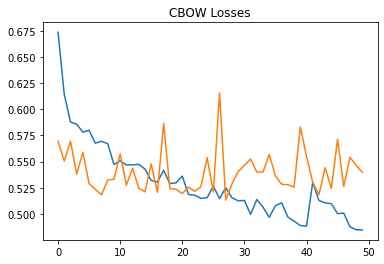

In [ ]:
## Simple Plotting Utility
def showPlot(title, *args):
    plt.figure()
    fig, ax = plt.subplots()
    for a in args:
      _ = ax.plot(a)
    _ = ax.set_title(title)
    
showPlot('CBOW Losses',train_losses,val_losses)


In [ ]:
torch.save(best_model,'/content/gdrive/My Drive/3dunet-supervised-pretrained-all-modalities.pt')

Device cuda


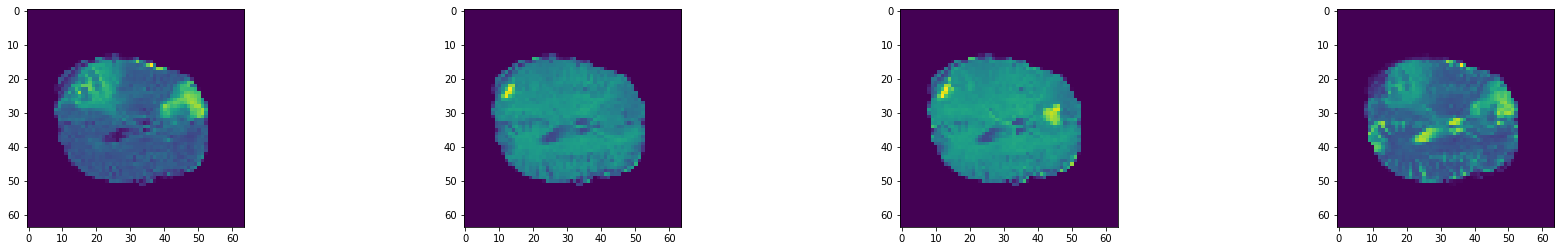

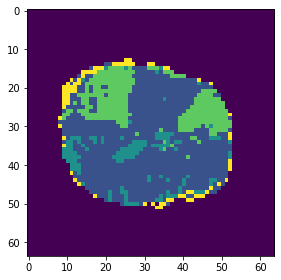

prediction


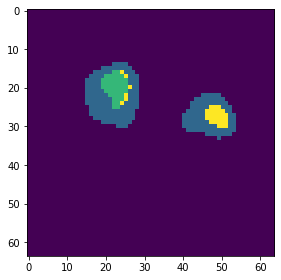

ground truth


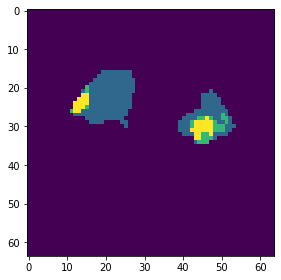

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

use_gpu=True
cuda0 = torch.device('cuda:0')
n_classes=4

model.eval()
slide = 17
for j,batch in enumerate(test_loader):
    if j == 2:
        

        inputs, targets = batch["img"], batch["seg"] # size of [B, Slice, H, W]

        # use only flair
        #inputs = inputs[:,0,:,:,:]
        #inputs = torch.unsqueeze(inputs,dim=1)

        inputs = inputs.permute(0,1,4,2,3)
        targets = targets.permute(0,1,4,2,3)

        #print('inputs',inputs.shape)

        
        # kmeans pre-training
        kmeans_input_3d = inputs[0,:,:,:,:].cpu().detach().numpy().reshape(4,32*64*64) # 4 modalities
        kmeans_input_3d=np.transpose(kmeans_input_3d)
        #print('kmeans_input_3d',kmeans_input_3d.shape)
        kmeans = KMeans(n_clusters=5, random_state=0).fit(kmeans_input_3d) 
        pseudolabels = kmeans.labels_

        
        pseudolabels = np.asarray(pseudolabels)
        #print('pseudolabels',pseudolabels.shape)
        
        # align the pseudolabels to be comparable with true labels
        count_0=sum(pseudolabels.flatten() == 0)
        count_1=sum(pseudolabels.flatten() == 1)
        count_2=sum(pseudolabels.flatten() == 2)
        count_3=sum(pseudolabels.flatten() == 3)
        count_4=sum(pseudolabels.flatten() == 4)
        count_dict={0:count_0, 1:count_1, 2:count_2, 3:count_3, 4:count_4}
        #print('count_dict',count_dict)
        sorted_count_dict = dict( sorted(count_dict.items(), key=operator.itemgetter(1),reverse=True))

        new_pseudolabels=np.empty([pseudolabels.shape[0]])
        classes = [0,1,2,3,4]
        counter = 0
        #print('sorted_count_dict.keys()',sorted_count_dict.keys())
        for label_sorted in sorted_count_dict.keys():
            new_pseudolabels[pseudolabels == label_sorted] = classes[counter]
            counter+=1
        #print('new pseudolabels',new_pseudolabels)
        #print('pseudolabels',pseudolabels.shape)
        
        
        
        new_pseudolabels=new_pseudolabels.reshape(inputs.shape[2], 64, 64)
        new_pseudolabels = torch.tensor(new_pseudolabels)
        new_pseudolabels=new_pseudolabels.unsqueeze(dim=0).cuda() # add first dimension, i.e. batch size (assume batch size = 1)

        new_pseudolabels_one_hot=new_pseudolabels.unsqueeze(dim=1)
        new_pseudolabels_one_hot = make_one_hot(new_pseudolabels_one_hot, 5) 
        #print('new_pseudolabels_one_hot',new_pseudolabels_one_hot.shape)

        if use_gpu:
            inputs = inputs.to(device)
            targets = targets.to(device)
            new_pseudolabels_one_hot = new_pseudolabels_one_hot.to(device)

        
        # visualize
        slide = 16
        new_pseudolabels_visualize = new_pseudolabels.permute(0,2,3,1).cpu().detach().numpy()
        inputs_visualize = inputs.permute(0,1,3,4,2).cpu().detach().numpy()

        plt.subplots(1, 4, figsize = (30,4))
        plt.subplot(1,4, 1);plt.imshow(inputs_visualize[0,0,...,slide])
        plt.subplot(1,4, 2);plt.imshow(inputs_visualize[0,1,...,slide])
        plt.subplot(1,4, 3);plt.imshow(inputs_visualize[0,2,...,slide])
        plt.subplot(1,4, 4);plt.imshow(inputs_visualize[0,3,...,slide])

        plt.subplots(1, 1, figsize = (30,4))
        plt.subplot(1,1, 1);plt.imshow(new_pseudolabels_visualize[0,...,slide])
        plt.tight_layout()
        plt.show()
        

    
        
        best_model.eval()

        #making predictions
        #y_pred = model(new_pseudolabels_one_hot.float())
        y_pred = best_model(new_pseudolabels_one_hot)
        #print('y_pred',y_pred.shape)

        
        
        # visualize
        slide = 16
        print('prediction')
        y_pred = torch.argmax(y_pred, dim = 1) 
        y_pred = y_pred.permute(0,2,3,1).cpu().detach().numpy()
        plt.subplots(1, 1, figsize = (30,4))
        plt.subplot(1,1, 1);plt.imshow(y_pred[0,...,slide])
        plt.tight_layout()
        plt.show()
        print('ground truth')
        targets = torch.argmax(targets, dim = 1) 
        targets = targets.permute(0,2,3,1).cpu().detach().numpy()
        plt.subplots(1, 1, figsize = (30,4))
        plt.subplot(1,1, 1);plt.imshow(targets[0,...,slide])
        plt.tight_layout()
        plt.show()

        
        break



In [ ]:
def dice_score_image(prediction, target, n_classes):
    '''
      computer the mean dice score for a single image

      Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
      Args:
          prediction (tensor): predictied labels of the image
          target (tensor): ground truth of the image
          n_classes (int): number of classes
    
      Returns:
          m_dice (float): Mean dice score over classes
    '''

    
    dice_classes = np.zeros(n_classes)
    
    pred_flat = prediction.contiguous().view(-1)
    target_flat = target.contiguous().view(-1)
    for cl in range(n_classes):
        TP = ((pred_flat == cl) * (target_flat == cl)).sum().item()
        FP = ((pred_flat == cl) * (target_flat != cl)).sum().item()
        FN = ((pred_flat != cl) * (target_flat == cl)).sum().item()

        

        #When there is no grount truth of the class in this image
        #Give 1 dice score if False Positive pixel number is 0, 
        #give 0 dice score if False Positive pixel number is not 0 (> 0).
        if not (target_flat == cl).any():
            dice_classes[cl] = 1 if FP == 0 else 0
        else:
            dice_classes[cl] = (2 * TP) / (2 * TP + FP + FN)
    return dice_classes.mean()

def dice_score_dataset(model, dataloader, num_classes, use_gpu=True):
    """
    Compute the mean dice score on a set of data.
    
    Note that multiclass dice score can be defined as the mean over classes of binary
    dice score. Dice score is computed per image. Mean dice score over the dataset is the dice
    score averaged across all images.
    
    Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
     
    Args:
        model (UNET class): Your trained model
        dataloader (DataLoader): Dataset for evaluation
        num_classes (int): Number of classes
    
    Returns:
        m_dice (float): Mean dice score over the input dataset
    """
    ## Number of Batches and Cache over Dataset 
    n_batches = len(dataloader)
    scores = np.zeros(n_batches)
    ## Evaluate
    model.eval()
    idx = 0
    for data in dataloader:
        ## Format Data
        inputs, targets = data["img"], data["seg"] # size of [B, Slice, H, W]

        # use only flair
        #inputs = inputs[:,0,:,:,:]
        #inputs = torch.unsqueeze(inputs,dim=1)

        inputs = inputs.permute(0,1,4,2,3)
        targets = targets.permute(0,1,4,2,3)

        #print('inputs',inputs.shape)

        
        # kmeans pre-training
        kmeans_input_3d = inputs[0,:,:,:,:].cpu().detach().numpy().reshape(4,32*64*64) # 4 modalities
        kmeans_input_3d=np.transpose(kmeans_input_3d)
        #print('kmeans_input_3d',kmeans_input_3d.shape)
        kmeans = KMeans(n_clusters=5, random_state=0).fit(kmeans_input_3d) 
        pseudolabels = kmeans.labels_

        
        pseudolabels = np.asarray(pseudolabels)
        #print('pseudolabels',pseudolabels.shape)
        
        # align the pseudolabels to be comparable with true labels
        count_0=sum(pseudolabels.flatten() == 0)
        count_1=sum(pseudolabels.flatten() == 1)
        count_2=sum(pseudolabels.flatten() == 2)
        count_3=sum(pseudolabels.flatten() == 3)
        count_4=sum(pseudolabels.flatten() == 4)
        count_dict={0:count_0, 1:count_1, 2:count_2, 3:count_3, 4:count_4}
        #print('count_dict',count_dict)
        sorted_count_dict = dict( sorted(count_dict.items(), key=operator.itemgetter(1),reverse=True))

        new_pseudolabels=np.empty([pseudolabels.shape[0]])
        classes = [0,1,2,3,4]
        counter = 0
        #print('sorted_count_dict.keys()',sorted_count_dict.keys())
        for label_sorted in sorted_count_dict.keys():
            new_pseudolabels[pseudolabels == label_sorted] = classes[counter]
            counter+=1
        #print('new pseudolabels',new_pseudolabels)
        #print('pseudolabels',pseudolabels.shape)
        
        
        
        new_pseudolabels=new_pseudolabels.reshape(inputs.shape[2], 64, 64)
        new_pseudolabels = torch.tensor(new_pseudolabels)
        new_pseudolabels=new_pseudolabels.unsqueeze(dim=0).cuda() # add first dimension, i.e. batch size (assume batch size = 1)

        new_pseudolabels_one_hot=new_pseudolabels.unsqueeze(dim=1)
        new_pseudolabels_one_hot = make_one_hot(new_pseudolabels_one_hot, 5) 
        #print('new_pseudolabels_one_hot',new_pseudolabels_one_hot.shape)

        if use_gpu:
            inputs = inputs.to(device)
            targets = targets.to(device)
            new_pseudolabels_one_hot = new_pseudolabels_one_hot.to(device)
    
        
        model.eval()

        #making predictions
        #y_pred = model(new_pseudolabels_one_hot.float())
        out = model(new_pseudolabels_one_hot)

        #out = functional.softmax(out, dim=1)
        n_classes = out.shape[1]
        images_per_batch = out.shape[0]
        
        prediction = torch.argmax(out, dim = 1) 
        targets = torch.argmax(targets, dim = 1)
        mean_score_per_batch=[]
        for image in range(images_per_batch):  
            mean_score_per_batch = dice_score_image(prediction[image,:,:,:], targets[image,:,:,:], n_classes)
        
        scores[idx] = np.mean(mean_score_per_batch)
        idx += 1
    ## Average Dice Score Over Images
    m_dice = scores.mean()
    return m_dice


In [ ]:
import time
start_time = time.time()
dice_score_dataset(best_model, test_loader, n_classes)
print("--- %s seconds ---" % (time.time() - start_time))

--- 55.351712465286255 seconds ---


In [ ]:
dice_score_dataset(best_model, test_loader, n_classes)

0.39561179611542047

# Train 3D Segmentation models from monai library
refer 2-d UNet: https://github.com/Project-MONAI/tutorials/blob/master/2d_segmentation/torch/unet_training_dict.py#L35
refer 3-d UNet: https://github.com/Project-MONAI/tutorials/blob/master/3d_segmentation/torch/unet_training_dict.py
refer Brant 3-d SegResNet: https://github.com/Project-MONAI/tutorials/blob/master/3d_segmentation/brats_segmentation_3d.ipynb

In [ ]:
# create 3D-UNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = monai.networks.nets.UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2
).to(device)
loss_function = monai.losses.DiceLoss(to_onehot_y = False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# start a typical PyTorch training
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
writer = SummaryWriter()
for epoch in range(10):
  print("-" * 10)
  print(f"epoch {epoch + 1}/{10}")
  model.train()
  epoch_loss = 0
  step = 0
  for batch_data in train_loader:
      step += 1
      inputs, labels = batch_data["img"].to(device), batch_data["seg"].to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_function(outputs, labels)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
      epoch_len = len(train_ds) // train_loader.batch_size
      print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
      writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
  epoch_loss /= step
  epoch_loss_values.append(epoch_loss)
  print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/10
1/5, train_loss: 0.9886
2/5, train_loss: 0.9828
3/5, train_loss: 0.9761
4/5, train_loss: 0.9787
5/5, train_loss: 0.9916
epoch 1 average loss: 0.9836
----------
epoch 2/10
1/5, train_loss: 0.9827
2/5, train_loss: 0.9754
3/5, train_loss: 0.9904
4/5, train_loss: 0.9733
5/5, train_loss: 0.9670
epoch 2 average loss: 0.9777
----------
epoch 3/10
1/5, train_loss: 0.9664
2/5, train_loss: 0.9719
3/5, train_loss: 0.9795
4/5, train_loss: 0.9722
5/5, train_loss: 0.9896
epoch 3 average loss: 0.9759
----------
epoch 4/10
1/5, train_loss: 0.9713
2/5, train_loss: 0.9895
3/5, train_loss: 0.9645
4/5, train_loss: 0.9715
5/5, train_loss: 0.9786
epoch 4 average loss: 0.9751
----------
epoch 5/10
1/5, train_loss: 0.9638
2/5, train_loss: 0.9705
3/5, train_loss: 0.9783
4/5, train_loss: 0.9893
5/5, train_loss: 0.9711
epoch 5 average loss: 0.9746
----------
epoch 6/10
1/5, train_loss: 0.9633
2/5, train_loss: 0.9707
3/5, train_loss: 0.9781
4/5, train_loss: 0.9892
5/5, train_loss: 0.9700
epo